<a href="https://colab.research.google.com/github/yogheswar/Metazord/blob/master/Finalcropprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install -q prophet pandas scikit-learn matplotlib pyngrok flask flask-cors


In [ ]:
# CELL 2: imports + helper
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle, json, os
from google.colab import files


In [ ]:
print("Upload your CSV (use the upload dialog).")
uploaded = files.upload()
fname = list(uploaded.keys())[0]
print("Loaded file:", fname)
df = pd.read_excel(fname)
df.head()

Upload your CSV (use the upload dialog).


Saving mtp_potato_dataset (1).xlsx to mtp_potato_dataset (1) (1).xlsx
Loaded file: mtp_potato_dataset (1) (1).xlsx


,STATE,District Name,Market Name,Commodity,Min_Price,Max_Price,Modal_Price,Price Date
0,Tamilnadu,coimbatore,Mettupalayam(Uzhavar Sandhai ),Onion,4000,4400,4400,2024-07-16
1,Tamilnadu,coimbatore,Mettupalayam(Uzhavar Sandhai ),Onion,4000,4400,4400,2024-07-17
2,Tamilnadu,coimbatore,Mettupalayam(Uzhavar Sandhai ),Onion,4000,4400,4400,2024-07-18
3,Tamilnadu,coimbatore,Mettupalayam(Uzhavar Sandhai ),Onion,4000,4400,4400,2024-07-19
4,Tamilnadu,coimbatore,Mettupalayam(Uzhavar Sandhai ),Onion,4000,4400,4400,2024-07-20


In [ ]:
# CELL 4: flexible column detection + convert to Prophet format (ds,y)
cols_lower = [c.lower() for c in df.columns]

# detect date column
if 'price date' in cols_lower:
    date_col = df.columns[cols_lower.index('price date')]
elif 'date' in cols_lower:
    date_col = df.columns[cols_lower.index('date')]
elif 'ds' in cols_lower:
    date_col = df.columns[cols_lower.index('ds')]
elif 'timestamp' in cols_lower:
    date_col = df.columns[cols_lower.index('timestamp')]
else:
    date_col = df.columns[0]   # fallback: first column

# detect price column
if 'modal_price' in cols_lower:
    price_col = df.columns[cols_lower.index('modal_price')]
elif 'price' in cols_lower:
    price_col = df.columns[cols_lower.index('price')]
elif 'value' in cols_lower:
    price_col = df.columns[cols_lower.index('value')]
elif 'y' in cols_lower:
    price_col = df.columns[cols_lower.index('y')]
else:
    price_col = df.columns[-1]  # fallback: last column


print("Using date column:", date_col)
print("Using price column:", price_col)

# prepare dataframe
df[date_col] = pd.to_datetime(df[date_col])
df = df[[date_col, price_col]].rename(columns={date_col:'ds', price_col:'y'})
df = df.dropna().sort_values('ds').reset_index(drop=True)
print("Data range:", df['ds'].min(), "->", df['ds'].max())
df.tail()

Using date column: Price Date
Using price column: Modal_Price
Data range: 2024-07-16 00:00:00 -> 2025-06-11 00:00:00


,ds,y
259,2025-06-06,2800
260,2025-06-07,2800
261,2025-06-08,2800
262,2025-06-09,2800
263,2025-06-11,3000


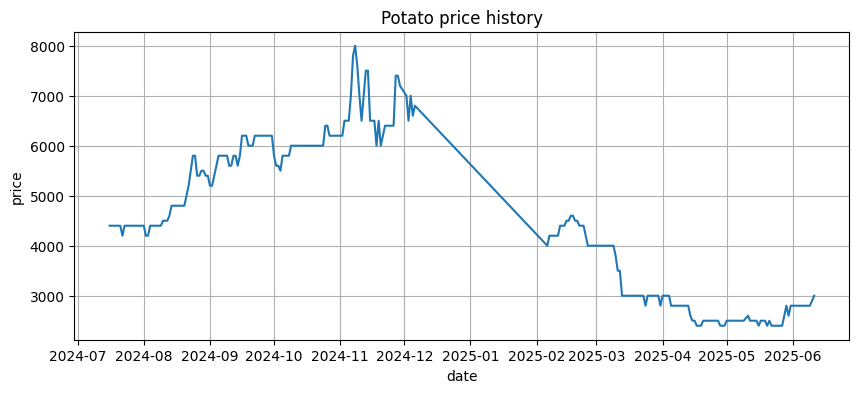

In [ ]:
# CELL 5: quick plot of history
plt.figure(figsize=(10,4))
plt.plot(df['ds'], df['y'], label='price')
plt.title("Potato price history")
plt.xlabel("date")
plt.ylabel("price")
plt.grid(True)
plt.show()


In [ ]:
# CELL 7: train Prophet on train and evaluate on test (if present)
m = Prophet()
m.fit(train)

# make predictions that cover test period
future_for_eval = m.make_future_dataframe(periods=test_days)
forecast_for_eval = m.predict(future_for_eval)

# merge preds with test
eval_df = forecast_for_eval[['ds','yhat']].merge(test[['ds','y']], on='ds', how='inner')
if not eval_df.empty:
    mae = mean_absolute_error(eval_df['y'], eval_df['yhat'])
    rmse = np.sqrt(mean_squared_error(eval_df['y'], eval_df['yhat']))
    print(f"Eval MAE: {mae:.4f}  RMSE: {rmse:.4f}")
else:
    print("No overlap between forecast and test (dataset too short for eval).")


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnn5db80b/gv9okl3e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnn5db80b/k72ou04j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53833', 'data', 'file=/tmp/tmpnn5db80b/gv9okl3e.json', 'init=/tmp/tmpnn5db80b/k72ou04j.json', 'output', 'file=/tmp/tmpnn5db80b/prophet_models89jvgys/prophet_model-20251004045546.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:55:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:55:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Eval MAE: 929.7379  RMSE: 1093.8298


In [ ]:
# CELL 6: simple train/test evaluation (last 30 days as test)
test_days = 30
if len(df) <= test_days + 5:
    print("Warning: dataset very small; skipping train/test split — training on full data.")
    train = df.copy()
    test = pd.DataFrame(columns=df.columns)
else:
    train = df.iloc[:-test_days].copy()
    test = df.iloc[-test_days:].copy()

print("Train rows:", len(train), "Test rows:", len(test))


Train rows: 234 Test rows: 30


In [ ]:
# CELL 7: train Prophet on train and evaluate on test (if present)
m = Prophet()
m.fit(train)

# make predictions that cover test period
future_for_eval = m.make_future_dataframe(periods=test_days)
forecast_for_eval = m.predict(future_for_eval)

# merge preds with test
eval_df = forecast_for_eval[['ds','yhat']].merge(test[['ds','y']], on='ds', how='inner')
if not eval_df.empty:
    mae = mean_absolute_error(eval_df['y'], eval_df['yhat'])
    rmse = np.sqrt(mean_squared_error(eval_df['y'], eval_df['yhat']))
    print(f"Eval MAE: {mae:.4f}  RMSE: {rmse:.4f}")
else:
    print("No overlap between forecast and test (dataset too short for eval).")


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnn5db80b/igy1ngvu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnn5db80b/51c01ssd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7179', 'data', 'file=/tmp/tmpnn5db80b/igy1ngvu.json', 'init=/tmp/tmpnn5db80b/51c01ssd.json', 'output', 'file=/tmp/tmpnn5db80b/prophet_modelb8trpqye/prophet_model-20251004050233.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:02:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:02:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Eval MAE: 824.7754  RMSE: 893.3113


In [ ]:
# CELL 8: train on FULL data and forecast next N months
N = 12   # number of months to forecast (change if needed)
m_full = Prophet()
m_full.fit(df)

# 👇 here we set freq='M' for monthly data
future_full = m_full.make_future_dataframe(periods=N, freq='M')
forecast_full = m_full.predict(future_full)

# Extract only the predicted future rows (after last date in original df)
future_preds = forecast_full[forecast_full['ds'] > df['ds'].max()][['ds','yhat','yhat_lower','yhat_upper']].reset_index(drop=True)
print("Predictions (next {} months):".format(N))
display(future_preds.head(10))



INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnn5db80b/lmd2a5nd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnn5db80b/bsjnwwck.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36981', 'data', 'file=/tmp/tmpnn5db80b/lmd2a5nd.json', 'init=/tmp/tmpnn5db80b/bsjnwwck.json', 'output', 'file=/tmp/tmpnn5db80b/prophet_model77lqe78o/prophet_model-20251004050431.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:04:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:04:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.12/dist-packages/

Predictions (next 12 months):


,ds,yhat,yhat_lower,yhat_upper
0,2025-06-30,2457.902089,2039.801865,2837.387016
1,2025-07-31,2498.234464,2023.162617,2930.864628
2,2025-08-31,2438.153546,1778.933861,3064.265650
3,2025-09-30,2338.990138,1446.812419,3171.226820
4,2025-10-31,2365.515274,1205.067938,3578.725957
5,2025-11-30,2319.693032,831.034850,3831.380933
6,2025-12-31,2307.339373,388.897985,4220.073868
7,2026-01-31,2228.388698,-47.519929,4675.433662
8,2026-02-28,2191.939309,-485.005433,5041.167003
9,2026-03-31,2102.069109,-1091.976780,5366.262522


In [ ]:
# CELL 9: save forecast CSV, save model (pickle) and metadata (last date)
future_preds.to_csv('potato_forecast_next_30.csv', index=False)
pickle.dump(m_full, open('prophet_model.pkl','wb'))

meta = {'last_date': df['ds'].max().strftime('%Y-%m-%d')}
with open('metadata.json','w') as f:
    json.dump(meta, f)

# download files to local machine
files.download('potato_forecast_next_30.csv')
files.download('prophet_model.pkl')
files.download('metadata.json')
print("Saved: potato_forecast_next_30.csv , prophet_model.pkl , metadata.json")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved: potato_forecast_next_30.csv , prophet_model.pkl , metadata.json


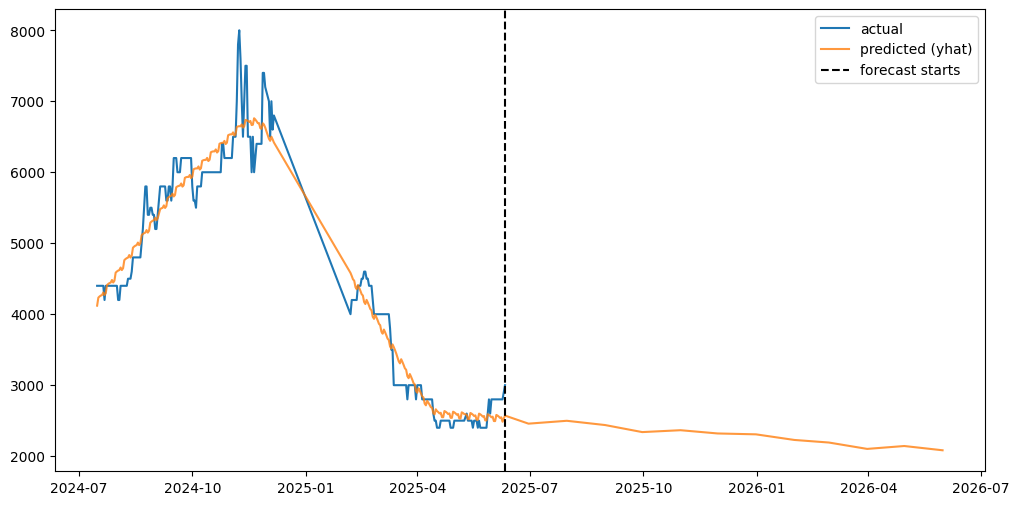

In [ ]:
# CELL 10: visual check: plot actual + predicted (full timeline)
plt.figure(figsize=(12,6))
plt.plot(df['ds'], df['y'], label='actual')
plt.plot(forecast_full['ds'], forecast_full['yhat'], label='predicted (yhat)', alpha=0.8)
plt.axvline(df['ds'].max(), linestyle='--', color='k', label='forecast starts')
plt.legend()
plt.show()
